# Imports #

In [6]:
import yfinance as yf
import datetime
import time
import matplotlib.pyplot as plt

# Getting the data #

In [4]:
stock_data = yf.download('AAPL', start='2016-01-01', end=datetime.date.today())

[*********************100%***********************]  1 of 1 completed


In [5]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.074739,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.471441,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.012112,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.040897,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.157446,283192000


Text(0, 0.5, 'Closing Price')

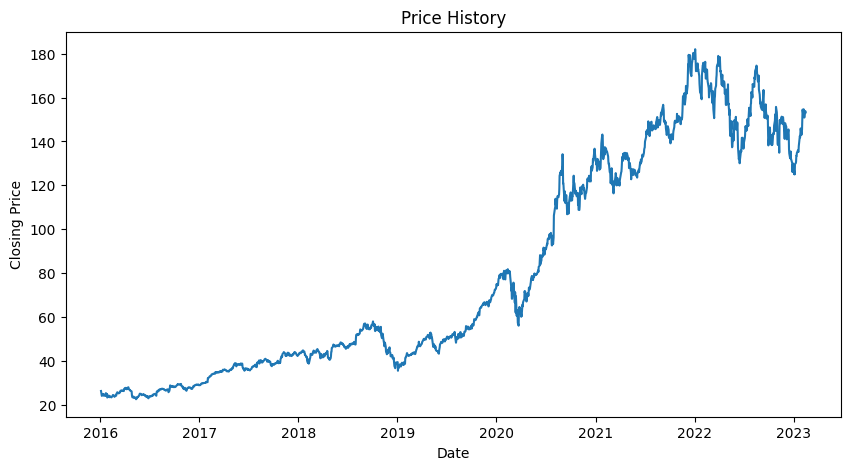

In [8]:
#Visualizing the data
plt.figure(figsize=(10, 5))
plt.title('Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')